<a href="https://colab.research.google.com/github/derekcarey/Covid-19_Vaccine_Tweet_Annotation_BERT/blob/main/Covid_19_Vaccine_Tweet_Annotation_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workbook Initiatlization and Data Preparation

## **Author: Derek Carey**

Corpus data as well as the code used for analysis is provided in a repository at https://github.com/derekcarey/Covid-19_Vaccine_Tweet_Annotation_BERT
. Inquiries should be directed to: derek.carey@outlook.com.[link text](https://)

## **About:**

The Covid-19_Vaccine_Tweet_Annotation_BERT notebook trains on a corpus of COVID-19 vaccine tweets to learn to perform several classification tasks associated with vaccination sentiment. Three models were downloaded from Tensorflow Hub, fined-tuned, and evaluated:

1. bert_en_cased_L-12_H-768_A-12/3
2. electra_base/2
3. bert_en_uncased_L-12_H-768_A-12/3


Always run the following Colab notebook section prior to executing code for any of the three 'Model Evaluation' sections. Due to memory constraints it is recommend to run each model segment as a seperate runtime. 


Install necessary Python libraries using pip. Future package changes require adjustments to code. 

In [1]:
!pip install tensorflow==2.4.1
!pip install  tensorflow-text==2.4.1   
!pip install tf-models-official==2.4
!pip install emoji

Import model packages. Set a random seed for Tensorflow to ensure results are repeatable

In [2]:
import pandas as pd
import os
import nltk
import re
import string
import shutil
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub
from official.nlp import optimization  # to create AdamW optmizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import emoji
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from google.colab import files
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

# Set random seed for tensorflow for model consistency
tf.random.set_seed(3)

Check to make sure GPU is in use

In [3]:
# Check to make sure GPU is in use

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Found GPU at: /device:GPU:0
Num GPUs Available:  1


Create a list to store model results. This will be appended once models are evaluated and eventually saved to a file. 

In [4]:
model_final_test_results = list()

The following function removes emojis from corpus text.

In [5]:
# Function: Takes in a text sequence as input and returns a sequence with emojis removed

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

Check to see if the corpus file is already on Github. If not, then download it from the Github repo.

In [6]:
import urllib.request

#set working Directory to where class corpus is saved.
os.chdir('/content')

# Check to see if the corpus file is already on Github. If not, then download it from the Github repo
if not os.path.exists("Covid_Vaccine_Tweet_Corpus.xlsx"):
  url = 'https://github.com/derekcarey/Covid-19_Vaccine_Tweet_Annotation_BERT/blob/main/Covid_Vaccine_Tweet_Corpus.xlsx?raw=true'
  print("download start!")
  filename, headers = urllib.request.urlretrieve(url, filename="Covid_Vaccine_Tweet_Corpus.xlsx")
  print("download complete!")
  print("download file location: ", filename)
  print("download headers: ", headers)


Set the Google colab directory to /content. Then use the Covid_Vaccine_Tweet_Corpus file to create a dataframe for processing. 

In [7]:
#set working Directory to where class corpus is saved.
os.chdir('/content')

#read in class corpus csv into python
data=pd.read_excel('Covid_Vaccine_Tweet_Corpus.xlsx','Corpus')


The corpus data file should only contain tweets related to vaccines. However, the dataframe is filtered to ensure only related tweets are included.

In [8]:
data = data[data['Vaccine Related']=='Yes']

Several additional fields are added to the corpus dataframe to convert text categories to a binary or categorical number. This step is required for processing labels. 

In [9]:

data['vaccination_label'] = data['Taken a Vaccine?'].apply(lambda x: 1 if x == 'Yes' or x == 'yes' else 0)
data['sentiment_label'] = data['Sentiment'].apply(lambda x: 0 if x == 'Positive' else 1 if x == 'Negative' else 2 if x == 'Neutral' else 2)
data['side_effect_label'] = data['Side Effects Referenced'].apply(lambda x: 1 if x == 'Yes' or x == 'yes' else 0)
data['negative_sentiment_reason_label'] = data['Negative Sentiment Reason'].apply(lambda x: 0 if x == 'Safety' else 1 if x == 'Efficacy'
                                                                         else 2 if x == 'Availability' else 3 if x == 'Other' else 4 if x == 'Not Negative' else 4)

Example of a record text with data (Negative sentiment rason is availability)

In [10]:
data.text[data['negative_sentiment_reason_label']==2].iloc[5]

'I’m an #essentialworker, #veterinarian, live in #YorkRegion(but not a hotspot area code)work in #Halton(but not hotspot area code)Too young for AZ,can’t work from home,can’t get #vaccinated I’m vaccine adjacent,not #vaccineeligible,terrified I’ll get #Covid and so 😡😩#onpoli'

Convert Emoji's in tweets to text so that they can be interpreted by BERT models

In [11]:
# Convert Emoji's in tweets to text so that they can be interpreted by BERT models
data['text'] = data['text'].apply(lambda x: emoji.demojize(x, delimiters=(" ", " "))) # 'game is on fire fire'

In [12]:
# Create a mapping of tfhub models for easy reference in later model construction

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}


The build_classifier_model_binary function is used to generate binary models for vaccine determination and side-effect classification tasks. 

In [13]:
def build_classifier_model_binary():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [14]:
def build_classifier_model_softmax_3_class():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [15]:
def build_classifier_model_softmax_5_class():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [16]:

def create_checkpoint_callback(checkpoint_filepath):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='binary_accuracy',
        mode='max',
        save_best_only=True)
    return checkpoint_callback


    
def create_checkpoint_callback_categorical(checkpoint_filepath):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='categorical_accuracy',
        mode='max',
        save_best_only=True)
    return checkpoint_callback

In [17]:
# Functions for calculating recall, precission, and f1 scores for models. 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Sizing of train, validation, and test datasets is determined by a percentage of the overall corpus size. For the corpus, dataset sizes are set and printed.

In [18]:

train_size = int(0.7 * len(data))
val_size = int(0.10 * len(data))
test_size = int(0.20 * len(data))

print('Train Size: ', train_size)
print('Validation Size: ', val_size)
print('Test Size: ', test_size)

Train Size:  1400
Validation Size:  200
Test Size:  400


In [19]:
from sklearn.utils import shuffle

shuffled_data = shuffle(data, random_state=65)

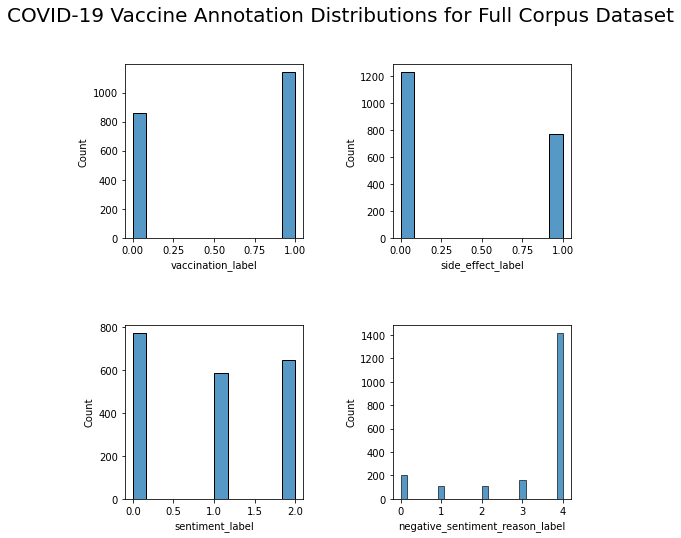

In [20]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(2, 2, 1)
sn.histplot(shuffled_data['vaccination_label'],ax=ax)
ax = fig.add_subplot(2, 2, 2)
sn.histplot(shuffled_data['side_effect_label'],ax=ax)
ax = fig.add_subplot(2, 2, 3)
sn.histplot(data = shuffled_data['sentiment_label'],ax=ax)
ax = fig.add_subplot(2, 2, 4)
sn.histplot(data=shuffled_data['negative_sentiment_reason_label'],ax=ax)
fig.suptitle('COVID-19 Vaccine Annotation Distributions for Full Corpus Dataset',fontsize=20)
fig.fontweight='bold'
plt.show()

In [21]:
train_data = shuffled_data[:train_size]

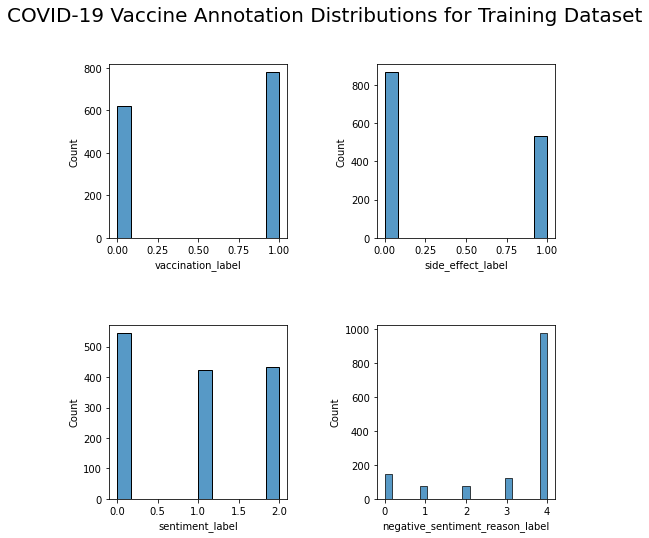

In [22]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(2, 2, 1)
sn.histplot(train_data['vaccination_label'],ax=ax)
ax = fig.add_subplot(2, 2, 2)
sn.histplot(train_data['side_effect_label'],ax=ax)
ax = fig.add_subplot(2, 2, 3)
sn.histplot(data = train_data['sentiment_label'],ax=ax)
ax = fig.add_subplot(2, 2, 4)
sn.histplot(data=train_data['negative_sentiment_reason_label'],ax=ax)
fig.suptitle('COVID-19 Vaccine Annotation Distributions for Training Dataset',fontsize=20)
fig.fontweight='bold'
plt.show()

In [23]:
test_data = shuffled_data[train_size:(train_size + test_size)]

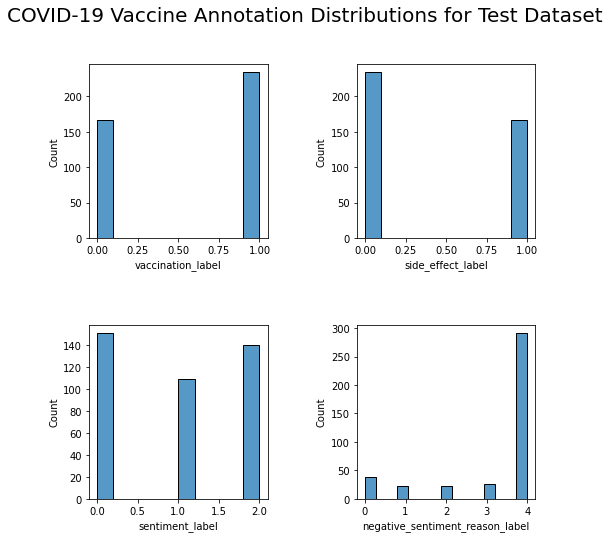

In [24]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(2, 2, 1)
sn.histplot(test_data['vaccination_label'],ax=ax)
ax = fig.add_subplot(2, 2, 2)
sn.histplot(test_data['side_effect_label'],ax=ax)
ax = fig.add_subplot(2, 2, 3)
sn.histplot(data = test_data['sentiment_label'],ax=ax)
ax = fig.add_subplot(2, 2, 4)
sn.histplot(data=test_data['negative_sentiment_reason_label'],ax=ax)
fig.suptitle('COVID-19 Vaccine Annotation Distributions for Test Dataset',fontsize=20)
fig.fontweight='bold'
plt.show()

In [25]:
val_data = shuffled_data[(train_size + test_size):]

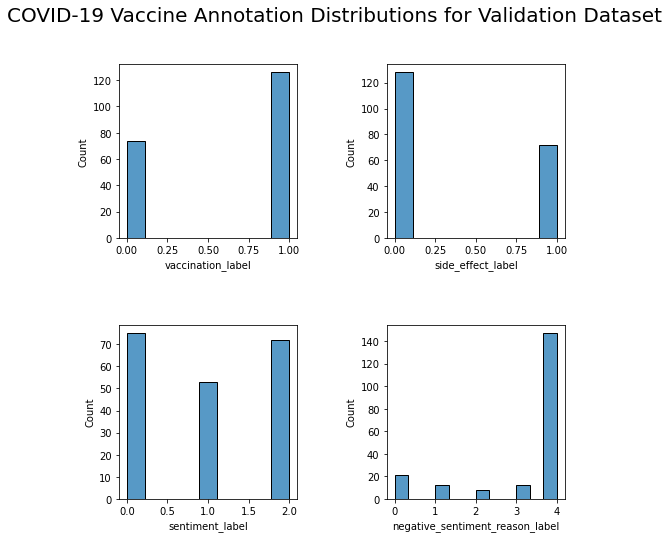

In [26]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(2, 2, 1)
sn.histplot(val_data['vaccination_label'],ax=ax)
ax = fig.add_subplot(2, 2, 2)
sn.histplot(val_data['side_effect_label'],ax=ax)
ax = fig.add_subplot(2, 2, 3)
sn.histplot(data = val_data['sentiment_label'],ax=ax)
ax = fig.add_subplot(2, 2, 4)
sn.histplot(data=val_data['negative_sentiment_reason_label'],ax=ax)
fig.suptitle('COVID-19 Vaccine Annotation Distributions for Validation Dataset',fontsize=20)
fig.fontweight='bold'
plt.show()

In [27]:
m1_train_target = train_data.pop('vaccination_label')
m1_val_target = val_data.pop('vaccination_label')
m1_test_target = test_data.pop('vaccination_label')

m2_train_target = train_data.pop('side_effect_label')
m2_val_target = val_data.pop('side_effect_label')
m2_test_target = test_data.pop('side_effect_label')

m3_train_target = train_data.pop('sentiment_label')
m3_val_target = val_data.pop('sentiment_label')
m3_test_target = test_data.pop('sentiment_label')

m4_train_target = train_data.pop('negative_sentiment_reason_label')
m4_val_target = val_data.pop('negative_sentiment_reason_label')
m4_test_target = test_data.pop('negative_sentiment_reason_label')

In [28]:
m1_train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'].values, m1_train_target.values)).batch(16)
m1_val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'].values, m1_val_target.values)).batch(16)
m1_test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'].values, m1_test_target.values)).batch(16)

m2_train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'].values, m2_train_target.values)).batch(16)
m2_val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'].values, m2_val_target.values)).batch(16)
m2_test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'].values, m2_test_target.values)).batch(16)

m3_train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'].values, to_categorical(m3_train_target))).batch(16)
m3_val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'].values, to_categorical(m3_val_target))).batch(16)
m3_test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'].values, to_categorical(m3_test_target))).batch(16)

m4_train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'].values, to_categorical(m4_train_target))).batch(16)
m4_val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'].values, to_categorical(m4_val_target))).batch(16)
m4_test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'].values, to_categorical(m4_test_target))).batch(16)

# BERT EN CASED Model Evaluation

## BERT EN CASED Classifer - Vaccine Determination

In [29]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

#,tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

In [30]:
epochs = 10

checkpoint_filepath = './m1_bert_cased/checkpoint'
model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m1_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [31]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [32]:
bert_model_name = 'bert_en_cased_L-12_H-768_A-12' 


tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3


In [33]:
bert_cased_m1 = build_classifier_model_binary()

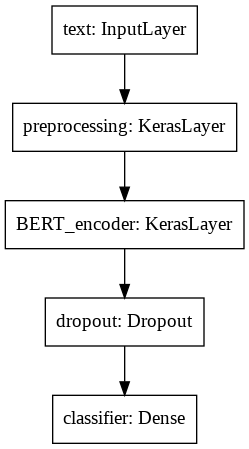

In [34]:
tf.keras.utils.plot_model(bert_cased_m1)

In [35]:


bert_cased_m1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [36]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_cased_m1.fit(m1_train_dataset,validation_data=m1_val_dataset, epochs=epochs,callbacks = [model_checkpoint_callback]) #callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 48s 312ms/step - loss: 0.6604 - binary_accuracy: 0.5947 - f1_m: 0.6333 - precision_m: 0.6458 - recall_m: 0.6911 - val_loss: 0.3527 - val_binary_accuracy: 0.8900 - val_f1_m: 0.9095 - val_precision_m: 0.9293 - val_recall_m: 0.9037
Epoch 2/10
88/88 [==============================] - 26s 297ms/step - loss: 0.2839 - binary_accuracy: 0.8937 - f1_m: 0.8968 - precision_m: 0.9312 - recall_m: 0.8779 - val_loss: 0.3704 - val_binary_accuracy: 0.8950 - val_f1_m: 0.9181 - val_precision_m: 0.9224 - val_recall_m: 0.9235
Epoch 3/10
88/88 [==============================] - 26s 297ms/step - loss: 0.1639 - binary_accuracy: 0.9469 - f1_m: 0.9490 - precision_m: 0.9632 - recall_m: 0.9416 - val_loss: 0.5201 - val_binary_accuracy: 0.8900 - val_f1_m: 0.9110 - val_precision_m: 0.8823 - val_recall_m: 0.9468
Epoch 4/10
88/88 [==============================] - 26s 298ms/step - loss: 0

In [37]:
bert_cased_m1.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


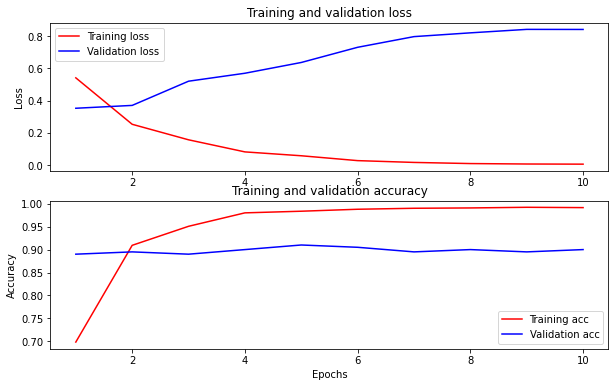

In [38]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [39]:
loss, accuracy, f1, precision, recall = bert_cased_m1.evaluate(m1_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 90.750003
Test Loss:  0.5276589393615723
Test Precision:  0.9443541169166565
Test Recall:  0.8974305987358093
Test f1_score:  0.9159671068191528


In [40]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m1_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(bert_cased_m1.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [41]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]



# Commented out code can be used to print text with predicted/actual labels. This is helpful for troubleshooting
# count = 0 

# while count < len(text_list):
#   print(text_list[count], predicted_categories[count], true_label_list[count])
#   count += 1


In [42]:
cm_1 = confusion_matrix(true_label_list, predicted_categories)

Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Taken Vaccine?')

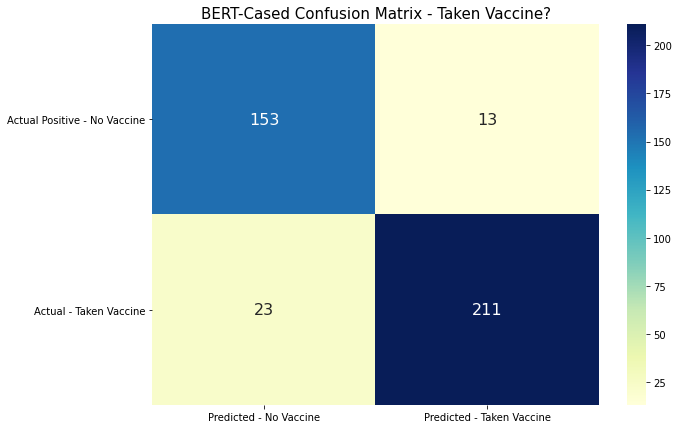

In [43]:


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_1, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('BERT-Cased Confusion Matrix - Taken Vaccine?',fontsize = 15)

In [44]:


# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)




# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'bert_cased_m1', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.91
Recall Score:  0.91
f1 Score:  0.91
Accuracy Score 0.91
Macro Precision Score:  0.9056412337662337
Macro Recall Score:  0.9116980743486768
Macro f1 Score:  0.9080671110089635
Accuracy Score 0.91


## BERT EN CASED Classifier - Side-Effect Determintation

In [45]:
epochs = 10

checkpoint_filepath = './m2_bert_cased/checkpoint'

model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m2_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [46]:
bert_cased_m2 = build_classifier_model_binary()


In [47]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [48]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [49]:
bert_cased_m2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [50]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_cased_m2.fit(m2_train_dataset,validation_data=m2_val_dataset, epochs=epochs, callbacks = [model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 46s 307ms/step - loss: 0.6611 - binary_accuracy: 0.6340 - f1_m: 0.0391 - precision_m: 0.0701 - recall_m: 0.0318 - val_loss: 0.3055 - val_binary_accuracy: 0.8650 - val_f1_m: 0.7705 - val_precision_m: 0.9308 - val_recall_m: 0.6886
Epoch 2/10
88/88 [==============================] - 26s 297ms/step - loss: 0.3745 - binary_accuracy: 0.8541 - f1_m: 0.7338 - precision_m: 0.8826 - recall_m: 0.6616 - val_loss: 0.2043 - val_binary_accuracy: 0.9450 - val_f1_m: 0.9079 - val_precision_m: 0.9872 - val_recall_m: 0.8485
Epoch 3/10
88/88 [==============================] - 26s 298ms/step - loss: 0.1945 - binary_accuracy: 0.9379 - f1_m: 0.9028 - precision_m: 0.9677 - recall_m: 0.8641 - val_loss: 0.3713 - val_binary_accuracy: 0.9000 - val_f1_m: 0.8395 - val_precision_m: 0.9106 - val_recall_m: 0.7945
Epoch 4/10
88/88 [==============================] - 26s 297ms/step - loss: 0

In [51]:
bert_cased_m2.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


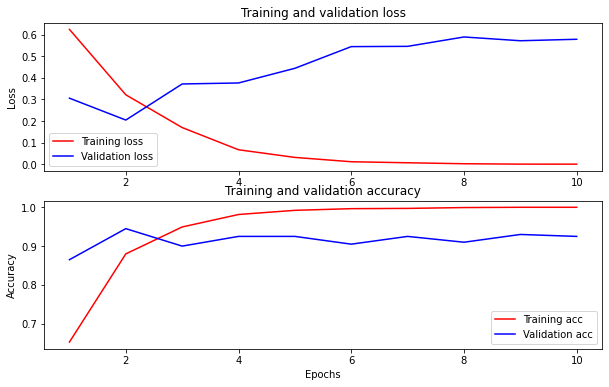

In [52]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [53]:
loss, accuracy, f1, precision, recall = bert_cased_m2.evaluate(m2_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 87.250000
Test Loss:  0.969865083694458
Test Precision:  0.8525079488754272
Test Recall:  0.8215844631195068
Test f1_score:  0.8234084844589233


In [54]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m2_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(bert_cased_m2.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


Convert probability vector into binary value of 0 (has not recieved vaccine) or 1 (has received a vaccine or has one scheduled)


In [55]:
# Convert probability vector to discrete 0 or 1 value (0 - no side effects, 1 - side effects)
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]

In [56]:
cm_2 = confusion_matrix(true_label_list, predicted_categories)

Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Side Effect Reference')

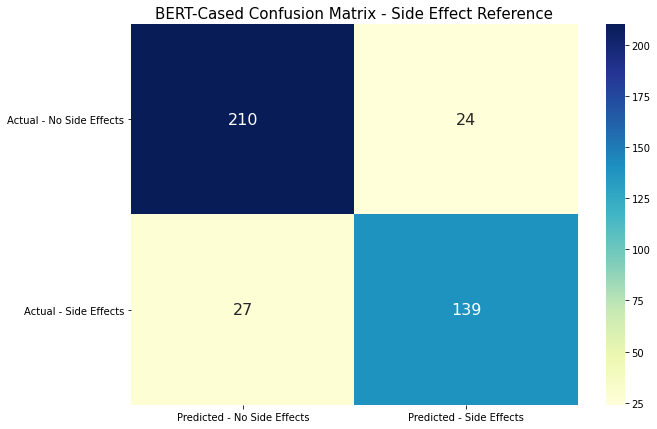

In [57]:

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_2, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('BERT-Cased Confusion Matrix - Side Effect Reference',fontsize = 15)

In [58]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'bert_cased_m2', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.8725
Recall Score:  0.8725
f1 Score:  0.8725
Accuracy Score 0.8725
Macro Precision Score:  0.8694183427817037
Macro Recall Score:  0.8673926475131295
Macro f1 Score:  0.8683522738272704


## BERT EN CASED Classifier - Sentiment Analysis

In [59]:
epochs = 10

checkpoint_filepath = './m3_bert_cased/checkpoint'

model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m3_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [60]:
bert_cased_m3 = build_classifier_model_softmax_3_class()


In [61]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [62]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [63]:


bert_cased_m3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [64]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_cased_m3.fit(m3_train_dataset,validation_data=m3_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 46s 308ms/step - loss: 1.2668 - categorical_accuracy: 0.3702 - f1_m: 0.2743 - precision_m: 0.4078 - recall_m: 0.2179 - val_loss: 0.7164 - val_categorical_accuracy: 0.6750 - val_f1_m: 0.6576 - val_precision_m: 0.7165 - val_recall_m: 0.6106
Epoch 2/10
88/88 [==============================] - 26s 297ms/step - loss: 0.7593 - categorical_accuracy: 0.6811 - f1_m: 0.6643 - precision_m: 0.7132 - recall_m: 0.6240 - val_loss: 0.5374 - val_categorical_accuracy: 0.8100 - val_f1_m: 0.7996 - val_precision_m: 0.8233 - val_recall_m: 0.7788
Epoch 3/10
88/88 [==============================] - 26s 297ms/step - loss: 0.4276 - categorical_accuracy: 0.8406 - f1_m: 0.8349 - precision_m: 0.8504 - recall_m: 0.8206 - val_loss: 0.6680 - val_categorical_accuracy: 0.8050 - val_f1_m: 0.8020 - val_precision_m: 0.8171 - val_recall_m: 0.7885
Epoch 4/10
88/88 [============================

In [65]:
bert_cased_m3.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


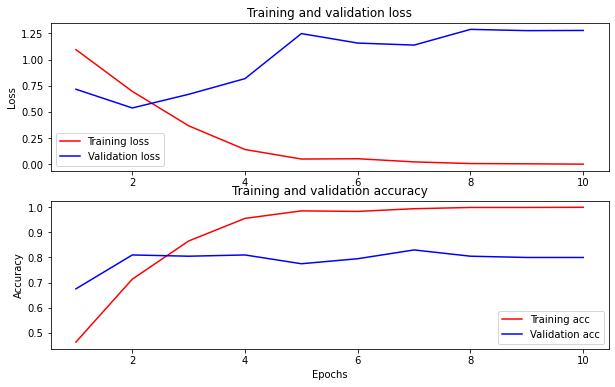

In [66]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [67]:
loss, accuracy, f1, precision, recall = bert_cased_m3.evaluate(m3_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 76.999998
Test Loss:  1.5614436864852905
Test Precision:  0.7721666693687439
Test Recall:  0.7699999809265137
Test f1_score:  0.771048367023468


In [68]:
# Generate Cofnusion Matrix from test_dataset - categorical classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m3_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    y_pred = tf.argmax(bert_cased_m3.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
 

  for item in batch[1]:
    
    true_label_list.append(tf.argmax(item))


Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Vaccine Sentiment')

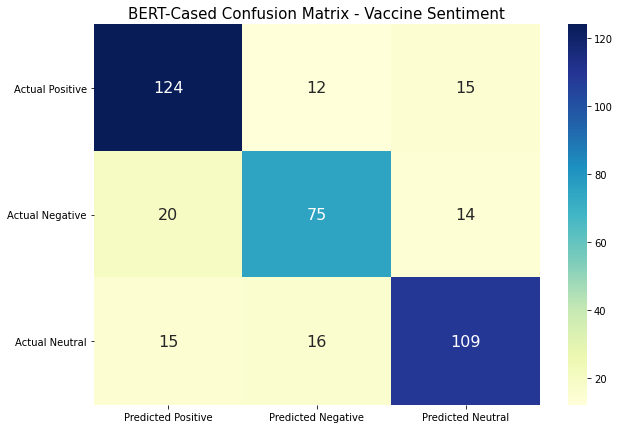

In [69]:
cm_3 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_3, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('BERT-Cased Confusion Matrix - Vaccine Sentiment',fontsize = 15)

In [70]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'bert_cased_m3', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.77
Recall Score:  0.77
f1 Score:  0.7699999999999999
Accuracy Score 0.77
Macro Precision Score:  0.765961542035357
Macro Recall Score:  0.7626122920156578
Macro f1 Score:  0.7639066105606082



 ## BERT EN CASED Classifier - Negative Sentiment Reason


In [71]:
epochs = 10

checkpoint_filepath = './m4_bert_cased/checkpoint'
model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m4_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [72]:
bert_cased_m4 = build_classifier_model_softmax_5_class()

In [73]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [74]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [75]:
bert_cased_m4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [76]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_cased_m4.fit(m4_train_dataset,validation_data=m4_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 46s 309ms/step - loss: 1.1738 - categorical_accuracy: 0.6214 - f1_m: 0.4645 - precision_m: 0.6768 - recall_m: 0.3996 - val_loss: 0.7045 - val_categorical_accuracy: 0.7400 - val_f1_m: 0.7653 - val_precision_m: 0.8551 - val_recall_m: 0.6971
Epoch 2/10
88/88 [==============================] - 26s 298ms/step - loss: 0.8045 - categorical_accuracy: 0.6984 - f1_m: 0.7013 - precision_m: 0.8684 - recall_m: 0.5978 - val_loss: 0.5567 - val_categorical_accuracy: 0.7900 - val_f1_m: 0.8001 - val_precision_m: 0.9135 - val_recall_m: 0.7212
Epoch 3/10
88/88 [==============================] - 26s 298ms/step - loss: 0.4461 - categorical_accuracy: 0.8416 - f1_m: 0.8324 - precision_m: 0.9060 - recall_m: 0.7748 - val_loss: 0.5708 - val_categorical_accuracy: 0.8100 - val_f1_m: 0.8066 - val_precision_m: 0.8320 - val_recall_m: 0.7837
Epoch 4/10
88/88 [============================

In [77]:
bert_cased_m4.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


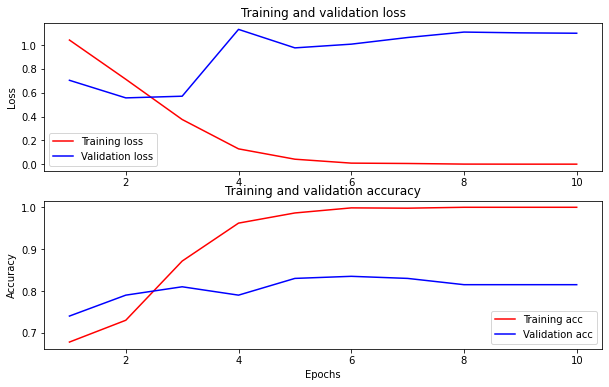

In [78]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [79]:
loss, accuracy, f1, precision, recall = bert_cased_m4.evaluate(m4_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 81.750000
Test Loss:  1.1159601211547852
Test Precision:  0.8221666812896729
Test Recall:  0.8174999952316284
Test f1_score:  0.8197579979896545


In [80]:
# Generate Cofnusion Matrix from test_dataset - categorical classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m4_test_dataset.as_numpy_iterator()):

  for item in batch[0]:
    #print(tf.argmax(classifier_model_sentiment.predict(tf.constant([item])),1))
    y_pred = tf.argmax(bert_cased_m4.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    #print(tf.argmax(item))
    true_label_list.append(tf.argmax(item))


Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Vaccine - Negative Sentiment Reason')

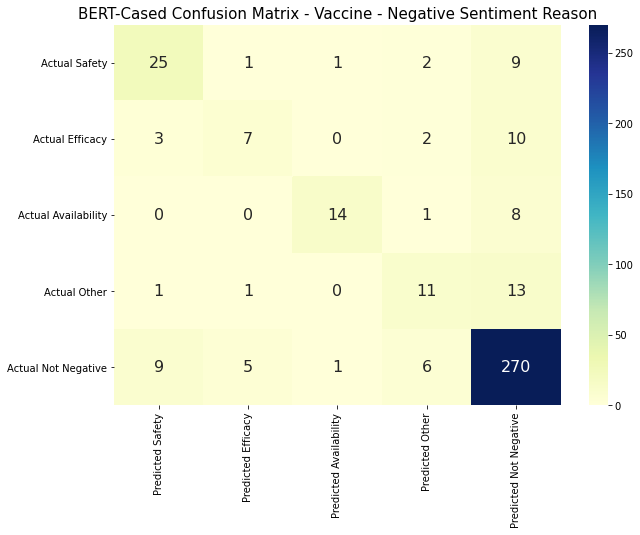

In [81]:
cm_4 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_4, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('BERT-Cased Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

In [82]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'bert_cased_m4', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.8175
Recall Score:  0.8175
f1 Score:  0.8175
Accuracy Score 0.8175
Macro Precision Score:  0.6807724957555179
Macro Recall Score:  0.5871368363642302
Macro f1 Score:  0.6243136345706624


Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Vaccine - Negative Sentiment Reason')

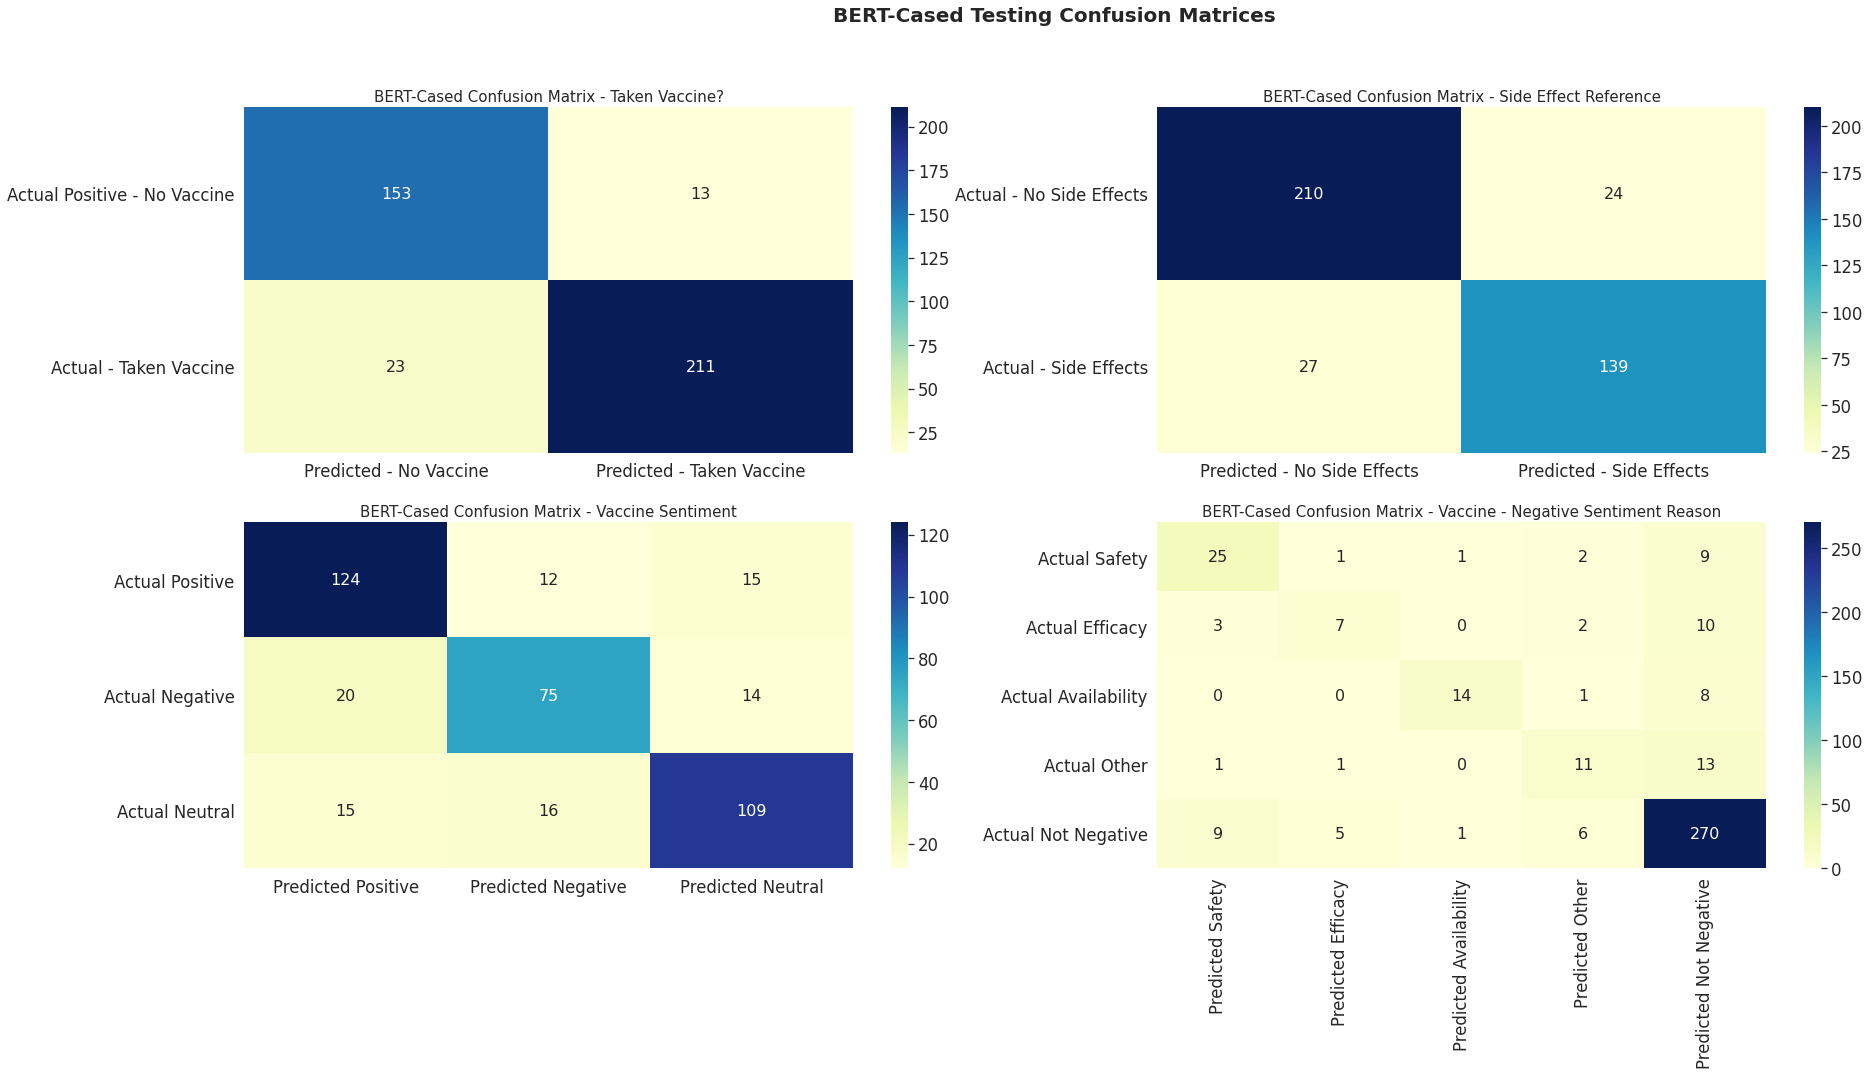

In [83]:
sn.set(font_scale=1.5)
fig, axes = plt.subplots(2, 2, figsize=(30, 14))

fig.suptitle('BERT-Cased Testing Confusion Matrices',fontsize = 20,fontweight='bold')
a = sn.heatmap(cm_1, ax=axes[0,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')
a.set_title('BERT-Cased Confusion Matrix - Taken Vaccine?',fontsize = 15)
b = sn.heatmap(cm_2, ax=axes[0,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')
b.set_title('BERT-Cased Confusion Matrix - Side Effect Reference',fontsize = 15)
c = sn.heatmap(cm_3,ax=axes[1,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')
c.set_title('BERT-Cased Confusion Matrix - Vaccine Sentiment',fontsize = 15)
d = sn.heatmap(data=cm_4, ax=axes[1,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')
d.set_title('BERT-Cased Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

# ELECTRA Model Evaluation

## ELECTRA Classifier - Vaccine Determintation

In [84]:
bert_model_name = 'electra_base' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [85]:
epochs = 10

checkpoint_filepath = './m1_electra_base/checkpoint'
model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m1_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [86]:
electra_m1 = build_classifier_model_binary()

In [87]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [88]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [89]:
electra_m1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [90]:
print(f'Training model with {tfhub_handle_encoder}')
history = electra_m1.fit(m1_train_dataset,validation_data=m1_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
88/88 [==============================] - 46s 308ms/step - loss: 0.5874 - binary_accuracy: 0.6420 - f1_m: 0.5818 - precision_m: 0.7700 - recall_m: 0.5126 - val_loss: 0.3086 - val_binary_accuracy: 0.8850 - val_f1_m: 0.9096 - val_precision_m: 0.9252 - val_recall_m: 0.9095
Epoch 2/10
88/88 [==============================] - 26s 298ms/step - loss: 0.2465 - binary_accuracy: 0.9156 - f1_m: 0.9132 - precision_m: 0.9425 - recall_m: 0.9006 - val_loss: 0.3505 - val_binary_accuracy: 0.9050 - val_f1_m: 0.9253 - val_precision_m: 0.9518 - val_recall_m: 0.9106
Epoch 3/10
88/88 [==============================] - 26s 298ms/step - loss: 0.1464 - binary_accuracy: 0.9606 - f1_m: 0.9593 - precision_m: 0.9781 - recall_m: 0.9443 - val_loss: 0.3644 - val_binary_accuracy: 0.8850 - val_f1_m: 0.9103 - val_precision_m: 0.9326 - val_recall_m: 0.9042
Epoch 4/10
88/88 [==============================] - 26s 297ms/step - loss: 0.0747 - binary_accura

In [91]:
electra_m1.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


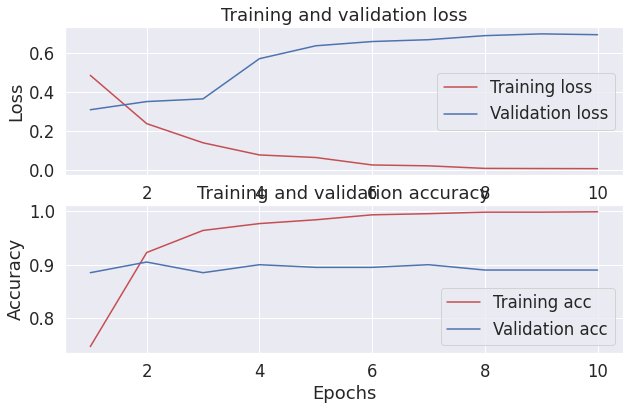

In [92]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [93]:
loss, accuracy, f1, precision, recall = electra_m1.evaluate(m1_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 94.999999
Test Loss:  0.33131828904151917
Test Precision:  0.9707985520362854
Test Recall:  0.9439692497253418
Test f1_score:  0.9552162289619446


In [94]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m1_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifier_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(electra_m1.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [95]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]


# count = 0 

# while count < len(text_list):
#   print(text_list[count], predicted_categories[count], true_label_list[count])
#   count += 1


Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Taken Vaccine?')

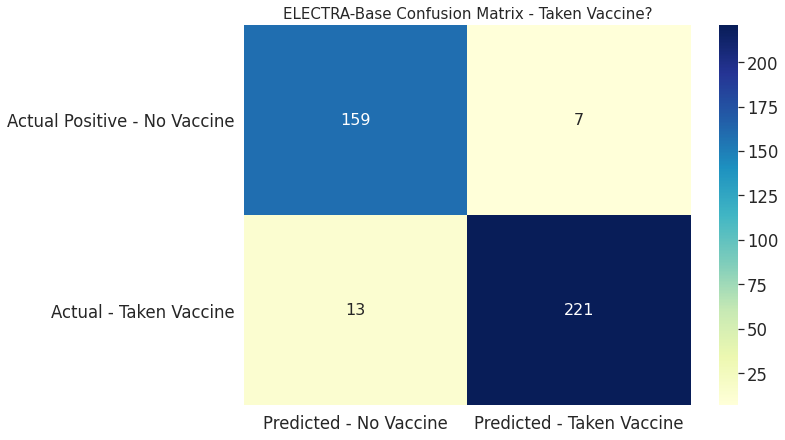

In [96]:
cm_1 = confusion_matrix(true_label_list, predicted_categories)


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_1, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('ELECTRA-Base Confusion Matrix - Taken Vaccine?',fontsize = 15)

In [97]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'electra_base_m1', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.95
Recall Score:  0.95
f1 Score:  0.9500000000000001
Accuracy Score 0.95
Macro Precision Score:  0.9468584251325989
Macro Recall Score:  0.9511378848728247
Macro f1 Score:  0.9487691795384103


## ELECTRA Classifier - Side-Effect Determination

In [98]:
epochs = 10

checkpoint_filepath = './m2_electra_base/checkpoint'

model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m2_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [99]:
electra_m2 = build_classifier_model_binary()


In [100]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [101]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [102]:
electra_m2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [103]:
print(f'Training model with {tfhub_handle_encoder}')
history = electra_m2.fit(m2_train_dataset,validation_data=m2_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
88/88 [==============================] - 46s 308ms/step - loss: 0.6668 - binary_accuracy: 0.6291 - f1_m: 0.0646 - precision_m: 0.1450 - recall_m: 0.0465 - val_loss: 0.3331 - val_binary_accuracy: 0.8450 - val_f1_m: 0.7155 - val_precision_m: 0.9808 - val_recall_m: 0.5764
Epoch 2/10
88/88 [==============================] - 26s 298ms/step - loss: 0.3980 - binary_accuracy: 0.8200 - f1_m: 0.6897 - precision_m: 0.8670 - recall_m: 0.6159 - val_loss: 0.2220 - val_binary_accuracy: 0.9150 - val_f1_m: 0.8529 - val_precision_m: 0.9582 - val_recall_m: 0.7949
Epoch 3/10
88/88 [==============================] - 26s 298ms/step - loss: 0.2059 - binary_accuracy: 0.9261 - f1_m: 0.8805 - precision_m: 0.9283 - recall_m: 0.8684 - val_loss: 0.4659 - val_binary_accuracy: 0.8900 - val_f1_m: 0.7944 - val_precision_m: 0.9846 - val_recall_m: 0.6942
Epoch 4/10
88/88 [==============================] - 26s 298ms/step - loss: 0.0826 - binary_accura

In [104]:
electra_m2.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


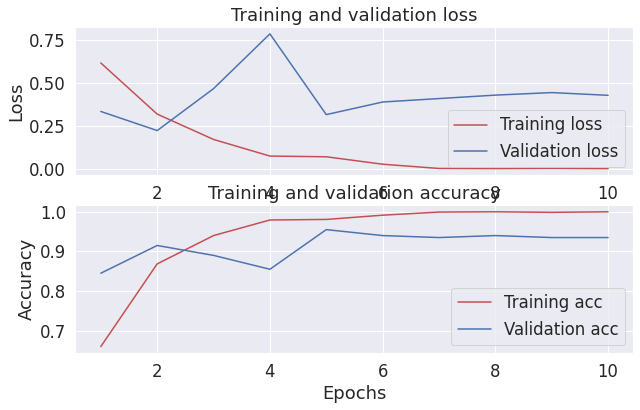

In [105]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [106]:
loss, accuracy, f1, precision, recall = electra_m2.evaluate(m2_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 89.499998
Test Loss:  0.6760417819023132
Test Precision:  0.8636810183525085
Test Recall:  0.8643477559089661
Test f1_score:  0.8556008338928223


In [107]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m2_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(electra_m2.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [108]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]

'''
count = 0 

while count < len(text_list):
  print(text_list[count], predicted_categories[count], true_label_list[count])
  count += 1
'''

'\ncount = 0 \n\nwhile count < len(text_list):\n  print(text_list[count], predicted_categories[count], true_label_list[count])\n  count += 1\n'

Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Side Effect Reference')

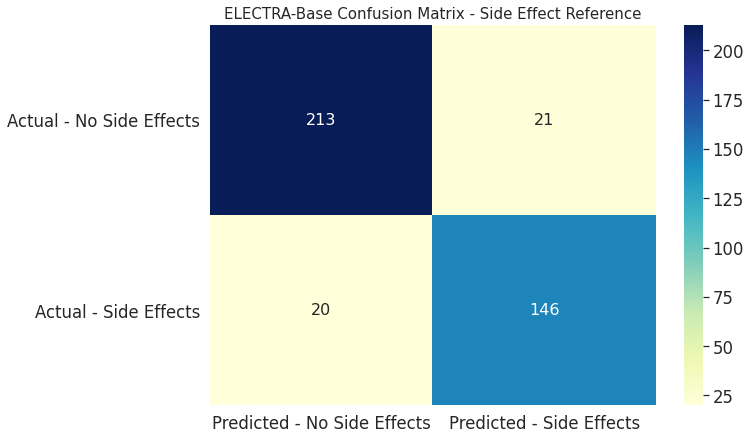

In [109]:
cm_2 = confusion_matrix(true_label_list, predicted_categories)


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_2, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('ELECTRA-Base Confusion Matrix - Side Effect Reference',fontsize = 15)

In [110]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'electra_base_m2', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.8975
Recall Score:  0.8975
f1 Score:  0.8975
Accuracy Score 0.8975
Macro Precision Score:  0.8942072935673717
Macro Recall Score:  0.8948872412727834
Macro f1 Score:  0.8945412221643485


## ELECTRA Classifier - Sentiment Analysis

In [111]:
# train_size = int(0.7 * len(m3_dataset))
# val_size = int(0.10 * len(m3_dataset))
# test_size = int(0.20 * len(m3_dataset))


# full_dataset = m3_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [112]:
epochs = 10

checkpoint_filepath = './m3_electra_base/checkpoint'

model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m3_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [113]:
electra_m3 = build_classifier_model_softmax_3_class()


In [114]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [115]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [116]:
electra_m3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [117]:
print(f'Training model with {tfhub_handle_encoder}')
history = electra_m3.fit(m3_train_dataset,validation_data=m3_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
88/88 [==============================] - 48s 309ms/step - loss: 1.1148 - categorical_accuracy: 0.3830 - f1_m: 0.1424 - precision_m: 0.3408 - recall_m: 0.0959 - val_loss: 0.6790 - val_categorical_accuracy: 0.7300 - val_f1_m: 0.7048 - val_precision_m: 0.7852 - val_recall_m: 0.6442
Epoch 2/10
88/88 [==============================] - 26s 298ms/step - loss: 0.7174 - categorical_accuracy: 0.6982 - f1_m: 0.6870 - precision_m: 0.7374 - recall_m: 0.6454 - val_loss: 0.6193 - val_categorical_accuracy: 0.7450 - val_f1_m: 0.7474 - val_precision_m: 0.7660 - val_recall_m: 0.7308
Epoch 3/10
88/88 [==============================] - 26s 298ms/step - loss: 0.4462 - categorical_accuracy: 0.8251 - f1_m: 0.8248 - precision_m: 0.8379 - recall_m: 0.8127 - val_loss: 0.6214 - val_categorical_accuracy: 0.7750 - val_f1_m: 0.7833 - val_precision_m: 0.7933 - val_recall_m: 0.7740
Epoch 4/10
88/88 [==============================] - 26s 298ms/step 

In [118]:
electra_m3.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


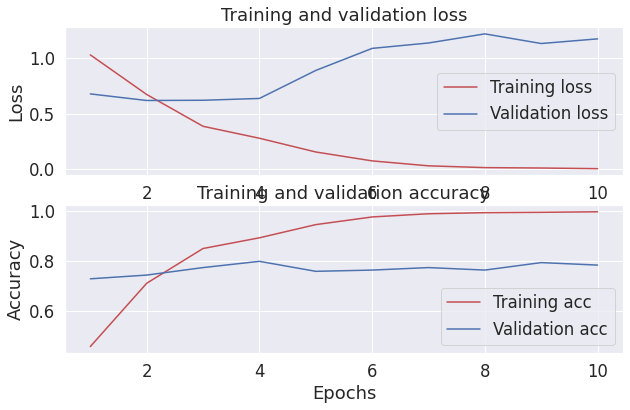

In [119]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [120]:
loss, accuracy, f1, precision, recall = electra_m3.evaluate(m3_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 79.750001
Test Loss:  1.1382355690002441
Test Precision:  0.7975000143051147
Test Recall:  0.7975000143051147
Test f1_score:  0.7974998950958252


In [121]:
# Generate Cofnusion Matrix from test_dataset - categorical classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m3_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.argmax(bert_cased_m3.predict(tf.constant([item])),1))
    y_pred = tf.argmax(electra_m3.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    #print(tf.argmax(item))
    true_label_list.append(tf.argmax(item))


Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Vaccine Sentiment')

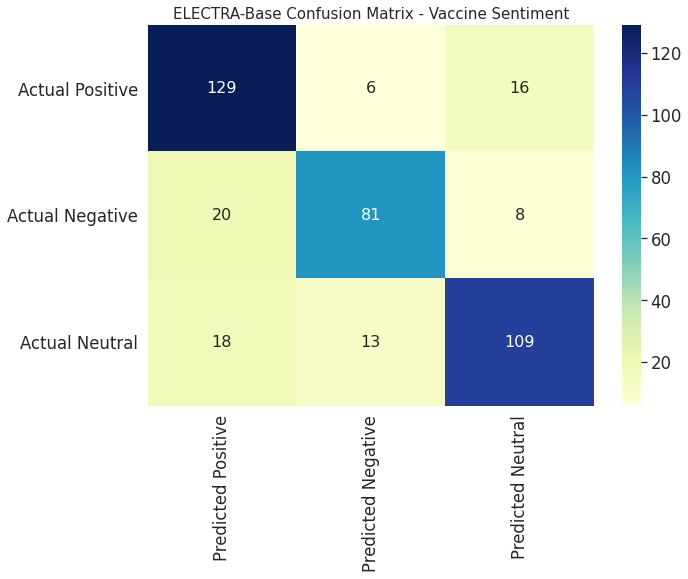

In [122]:
cm_3 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_3, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('ELECTRA-Base Confusion Matrix - Vaccine Sentiment',fontsize = 15)

In [123]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'electra_base_m3', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.7975
Recall Score:  0.7975
f1 Score:  0.7975
Accuracy Score 0.7975
Macro Precision Score:  0.8006679873336034
Macro Recall Score:  0.7919984434626879
Macro f1 Score:  0.79499172349222


## ELECTRA Classifier - Negative Sentiment Reason

In [124]:
epochs = 10

checkpoint_filepath = './m4_electra_base/checkpoint'
model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m4_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [125]:
electra_m4 = build_classifier_model_softmax_5_class()

In [126]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [127]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [128]:
electra_m4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [129]:
print(f'Training model with {tfhub_handle_encoder}')
history = electra_m4.fit(m4_train_dataset,validation_data=m4_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
88/88 [==============================] - 47s 309ms/step - loss: 1.1546 - categorical_accuracy: 0.6342 - f1_m: 0.4353 - precision_m: 0.6533 - recall_m: 0.3913 - val_loss: 0.6892 - val_categorical_accuracy: 0.7400 - val_f1_m: 0.7619 - val_precision_m: 0.8250 - val_recall_m: 0.7115
Epoch 2/10
88/88 [==============================] - 26s 298ms/step - loss: 0.8026 - categorical_accuracy: 0.6984 - f1_m: 0.6981 - precision_m: 0.8415 - recall_m: 0.6057 - val_loss: 0.6117 - val_categorical_accuracy: 0.7800 - val_f1_m: 0.7934 - val_precision_m: 0.8654 - val_recall_m: 0.7356
Epoch 3/10
88/88 [==============================] - 26s 298ms/step - loss: 0.5022 - categorical_accuracy: 0.8104 - f1_m: 0.8020 - precision_m: 0.8847 - recall_m: 0.7379 - val_loss: 0.6440 - val_categorical_accuracy: 0.8150 - val_f1_m: 0.8201 - val_precision_m: 0.8450 - val_recall_m: 0.7981
Epoch 4/10
88/88 [==============================] - 26s 298ms/step 

In [130]:
electra_m4.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


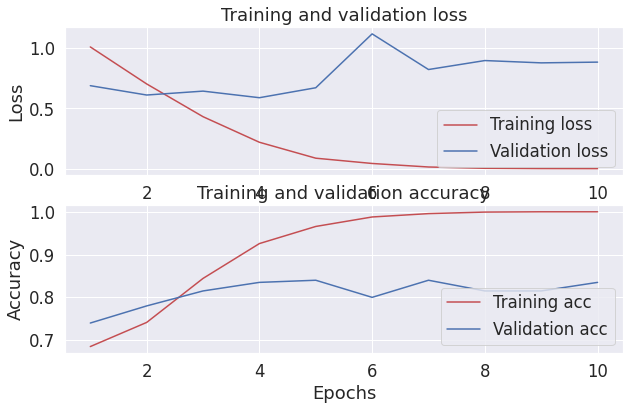

In [131]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [132]:
loss, accuracy, f1, precision, recall = electra_m4.evaluate(m4_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 85.750002
Test Loss:  0.7945043444633484
Test Precision:  0.8575000166893005
Test Recall:  0.8575000166893005
Test f1_score:  0.857499897480011


In [133]:
# Generate Cofnusion Matrix from test_dataset - categorical classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m4_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    y_pred = tf.argmax(electra_m4.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    #print(tf.argmax(item))
    true_label_list.append(tf.argmax(item))


Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Vaccine - Negative Sentiment Reason')

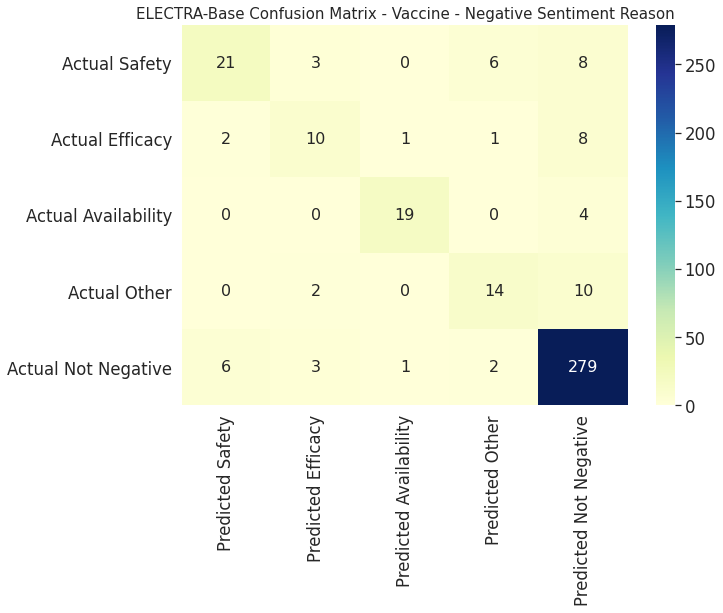

In [134]:
cm_4 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_4, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('ELECTRA-Base Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

In [135]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'electra_base_m4', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.8575
Recall Score:  0.8575
f1 Score:  0.8575
Accuracy Score 0.8575
Macro Precision Score:  0.739212732977016
Macro Recall Score:  0.6660976830148078
Macro f1 Score:  0.6983861213413454


Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Vaccine - Negative Sentiment Reason')

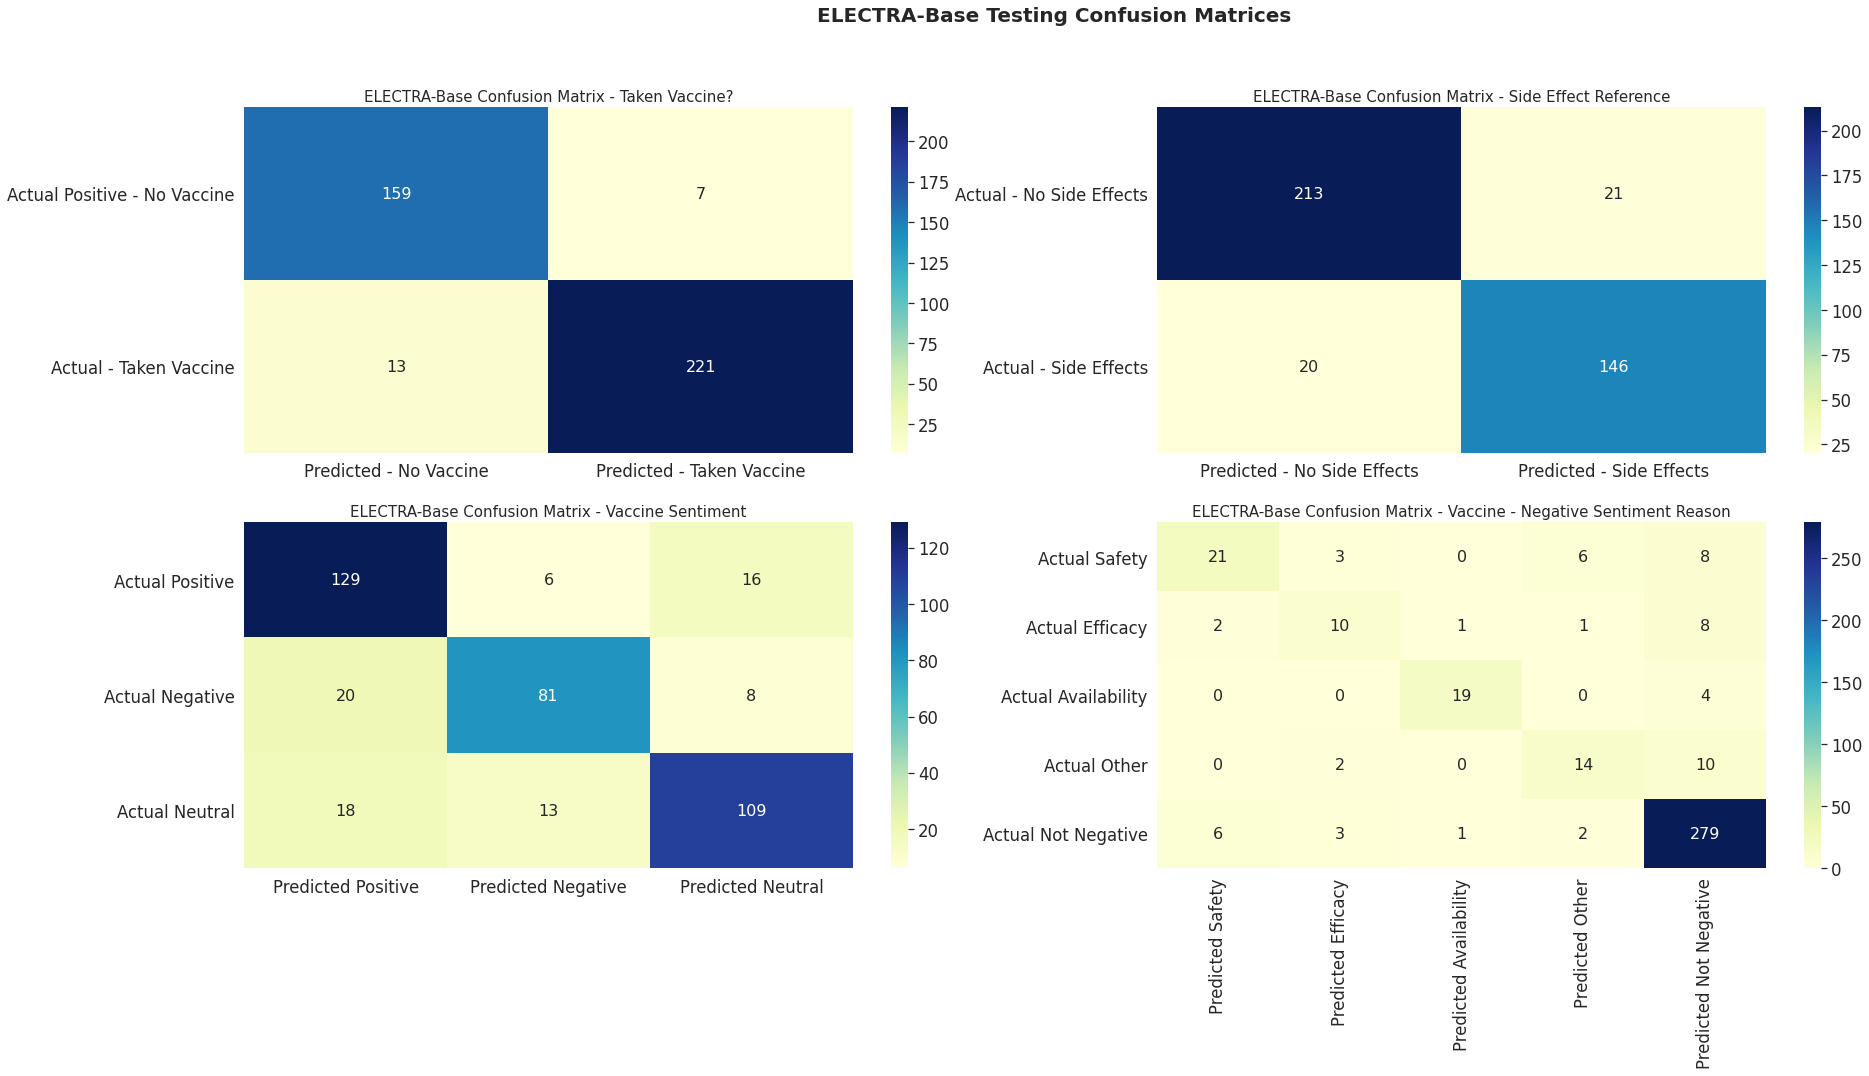

In [136]:
sn.set(font_scale=1.5)
fig, axes = plt.subplots(2, 2, figsize=(30, 14))

fig.suptitle('ELECTRA-Base Testing Confusion Matrices',fontsize = 20,fontweight='bold')
a = sn.heatmap(cm_1, ax=axes[0,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')
a.set_title('ELECTRA-Base Confusion Matrix - Taken Vaccine?',fontsize = 15)
b = sn.heatmap(cm_2, ax=axes[0,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')
b.set_title('ELECTRA-Base Confusion Matrix - Side Effect Reference',fontsize = 15)
c = sn.heatmap(cm_3,ax=axes[1,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')
c.set_title('ELECTRA-Base Confusion Matrix - Vaccine Sentiment',fontsize = 15)
d = sn.heatmap(data=cm_4, ax=axes[1,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')
d.set_title('ELECTRA-Base Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

# BERT EN UNCASED Model Evaluation

## BERT EN UNCASED Classifier - Vaccine Classification

In [29]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [30]:

epochs = 10

checkpoint_filepath = './m1_bert_uncased/checkpoint'
model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m1_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)


In [31]:
bert_uncased_m1 = build_classifier_model_binary()

In [32]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [33]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [34]:
bert_uncased_m1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [35]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased_m1.fit(m1_train_dataset,validation_data=m1_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 48s 311ms/step - loss: 0.6138 - binary_accuracy: 0.6026 - f1_m: 0.5247 - precision_m: 0.7071 - recall_m: 0.4518 - val_loss: 0.3099 - val_binary_accuracy: 0.8950 - val_f1_m: 0.9120 - val_precision_m: 0.9518 - val_recall_m: 0.8890
Epoch 2/10
88/88 [==============================] - 26s 297ms/step - loss: 0.2650 - binary_accuracy: 0.9019 - f1_m: 0.9060 - precision_m: 0.9366 - recall_m: 0.8899 - val_loss: 0.3411 - val_binary_accuracy: 0.9100 - val_f1_m: 0.9239 - val_precision_m: 0.9518 - val_recall_m: 0.9096
Epoch 3/10
88/88 [==============================] - 26s 296ms/step - loss: 0.1394 - binary_accuracy: 0.9598 - f1_m: 0.9565 - precision_m: 0.9811 - recall_m: 0.9419 - val_loss: 0.3862 - val_binary_accuracy: 0.9200 - val_f1_m: 0.9351 - val_precision_m: 0.9422 - val_recall_m: 0.9349
Epoch 4/10
88/88 [==============================] - 26s 297ms/step - loss:

In [36]:
bert_uncased_m1.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


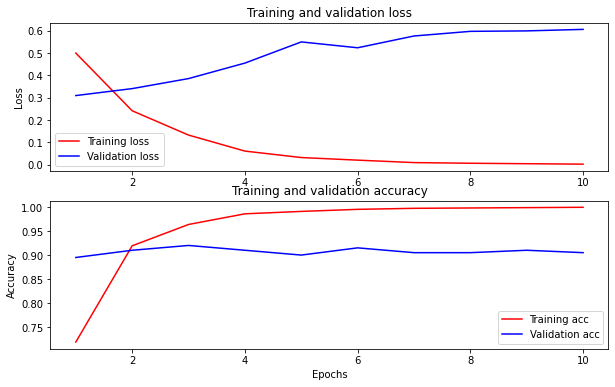

In [37]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [38]:
loss, accuracy, f1, precision, recall = bert_uncased_m1.evaluate(m1_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 92.250001
Test Loss:  0.4456292986869812
Test Precision:  0.9384146332740784
Test Recall:  0.9310932755470276
Test f1_score:  0.9324251413345337


In [39]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m1_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifier_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(bert_uncased_m1.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [40]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]


# count = 0 

# while count < len(text_list):
#   print(text_list[count], predicted_categories[count], true_label_list[count])
#   count += 1


Text(0.5, 1.0, 'Bert-Uncased Confusion Matrix - Taken Vaccine?')

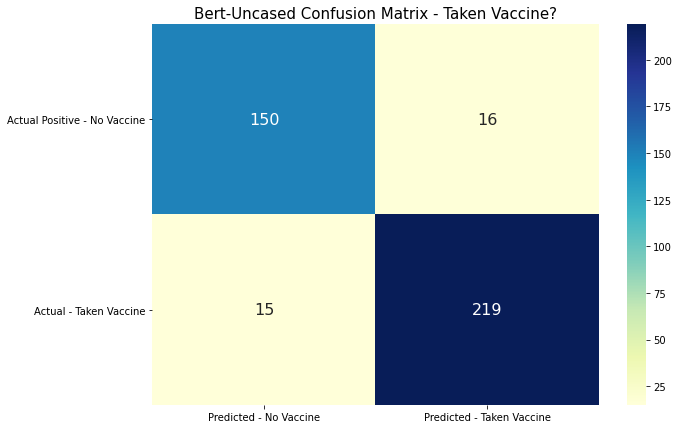

In [41]:
cm_1 = confusion_matrix(true_label_list, predicted_categories)


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_1, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('Bert-Uncased Confusion Matrix - Taken Vaccine?',fontsize = 15)

In [42]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'bert_uncased_m1', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.9225
Recall Score:  0.9225
f1 Score:  0.9225
Accuracy Score 0.9225
Macro Precision Score:  0.9205029013539652
Macro Recall Score:  0.9197559468643806
Macro f1 Score:  0.9201231649263393


##BERT EN UNCASED Classifier - Side-Effect Determination

In [43]:
epochs = 10

checkpoint_filepath = './m2_bert_uncased/checkpoint'

model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m2_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [44]:
bert_uncased_m2 = build_classifier_model_binary()


In [45]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [46]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [47]:
bert_uncased_m2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [48]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased_m2.fit(m2_train_dataset,validation_data=m2_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 48s 307ms/step - loss: 0.6755 - binary_accuracy: 0.6314 - f1_m: 0.0588 - precision_m: 0.1377 - recall_m: 0.0426 - val_loss: 0.3151 - val_binary_accuracy: 0.8550 - val_f1_m: 0.7722 - val_precision_m: 0.9192 - val_recall_m: 0.6712
Epoch 2/10
88/88 [==============================] - 26s 297ms/step - loss: 0.3741 - binary_accuracy: 0.8430 - f1_m: 0.7230 - precision_m: 0.8823 - recall_m: 0.6409 - val_loss: 0.2099 - val_binary_accuracy: 0.9250 - val_f1_m: 0.8865 - val_precision_m: 0.9524 - val_recall_m: 0.8383
Epoch 3/10
88/88 [==============================] - 26s 297ms/step - loss: 0.1700 - binary_accuracy: 0.9393 - f1_m: 0.8952 - precision_m: 0.9632 - recall_m: 0.8613 - val_loss: 0.3219 - val_binary_accuracy: 0.9250 - val_f1_m: 0.8837 - val_precision_m: 0.9396 - val_recall_m: 0.8426
Epoch 4/10
88/88 [==============================] - 26s 297ms/step - loss:

In [49]:
bert_uncased_m2.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


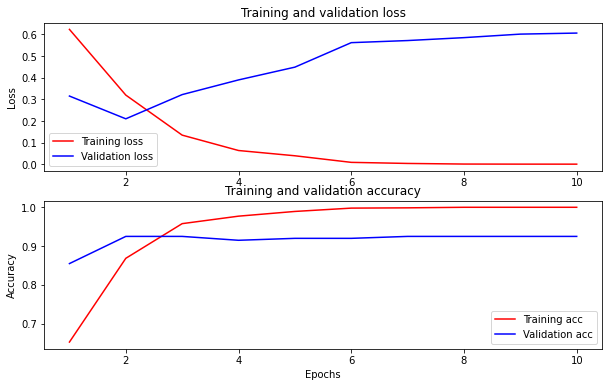

In [50]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [51]:
loss, accuracy, f1, precision, recall = bert_uncased_m2.evaluate(m2_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 87.500000
Test Loss:  0.9139888286590576
Test Precision:  0.8506290912628174
Test Recall:  0.8497287631034851
Test f1_score:  0.8332461714744568


In [52]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m2_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(bert_uncased_m2.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [53]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]

'''
count = 0 

while count < len(text_list):
  print(text_list[count], predicted_categories[count], true_label_list[count])
  count += 1
'''

'\ncount = 0 \n\nwhile count < len(text_list):\n  print(text_list[count], predicted_categories[count], true_label_list[count])\n  count += 1\n'

Text(0.5, 1.0, 'Bert-Uncased Confusion Matrix - Side Effect Reference')

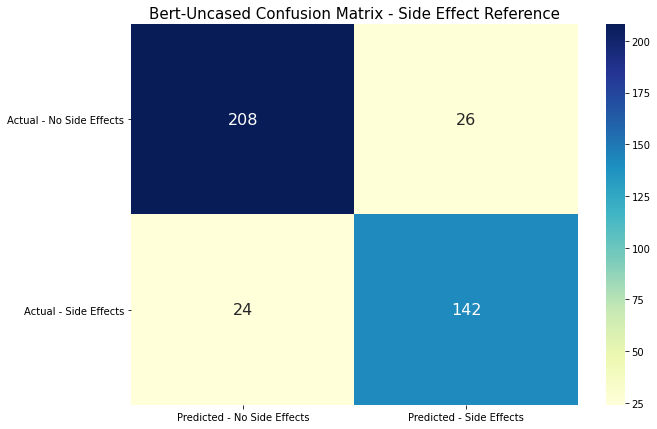

In [54]:
cm_2 = confusion_matrix(true_label_list, predicted_categories)


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_2, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('Bert-Uncased Confusion Matrix - Side Effect Reference',fontsize = 15)

In [55]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'bert_uncased_m2', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.875
Recall Score:  0.875
f1 Score:  0.875
Accuracy Score 0.875
Macro Precision Score:  0.8708949096880132
Macro Recall Score:  0.8721552878179384
Macro f1 Score:  0.8715016319292744


##BERT EN UNCASED Classifier - Sentiment Analysis

In [56]:
epochs = 10

checkpoint_filepath = './m3_bert_uncased_/checkpoint'

model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m3_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [57]:
bert_uncased_m3 = build_classifier_model_softmax_3_class()


In [58]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [59]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [60]:
bert_uncased_m3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [61]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased_m3.fit(m3_train_dataset,validation_data=m3_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 47s 308ms/step - loss: 1.1366 - categorical_accuracy: 0.3992 - f1_m: 0.2657 - precision_m: 0.4349 - recall_m: 0.2013 - val_loss: 0.6675 - val_categorical_accuracy: 0.6800 - val_f1_m: 0.6667 - val_precision_m: 0.7035 - val_recall_m: 0.6346
Epoch 2/10
88/88 [==============================] - 26s 297ms/step - loss: 0.7565 - categorical_accuracy: 0.6654 - f1_m: 0.6487 - precision_m: 0.6954 - recall_m: 0.6099 - val_loss: 0.5670 - val_categorical_accuracy: 0.7700 - val_f1_m: 0.7828 - val_precision_m: 0.8087 - val_recall_m: 0.7596
Epoch 3/10
88/88 [==============================] - 26s 296ms/step - loss: 0.5056 - categorical_accuracy: 0.8149 - f1_m: 0.8075 - precision_m: 0.8291 - recall_m: 0.7883 - val_loss: 0.6406 - val_categorical_accuracy: 0.7650 - val_f1_m: 0.7712 - val_precision_m: 0.7787 - val_recall_m: 0.7644
Epoch 4/10
88/88 [==========================

In [62]:
bert_uncased_m3.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


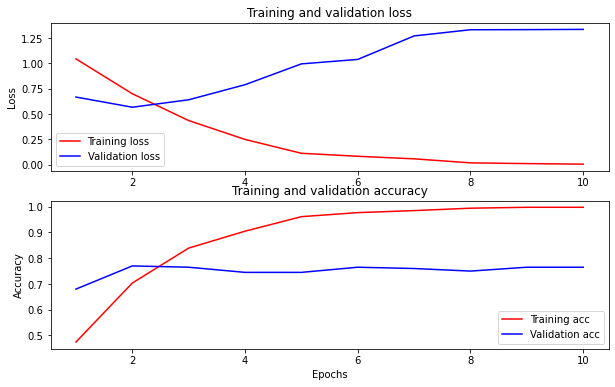

In [63]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [64]:
loss, accuracy, f1, precision, recall = bert_uncased_m3.evaluate(m3_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 77.749997
Test Loss:  1.2528870105743408
Test Precision:  0.7774999737739563
Test Recall:  0.7774999737739563
Test f1_score:  0.7774999141693115


In [65]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m3_test_dataset.as_numpy_iterator()):

  for item in batch[0]:


    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.argmax(bert_uncased_m3.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

    

  for item in batch[1]:
    true_label_list.append(tf.argmax(item))


Text(0.5, 1.0, 'Bert-Uncased Confusion Matrix - Vaccine Sentiment')

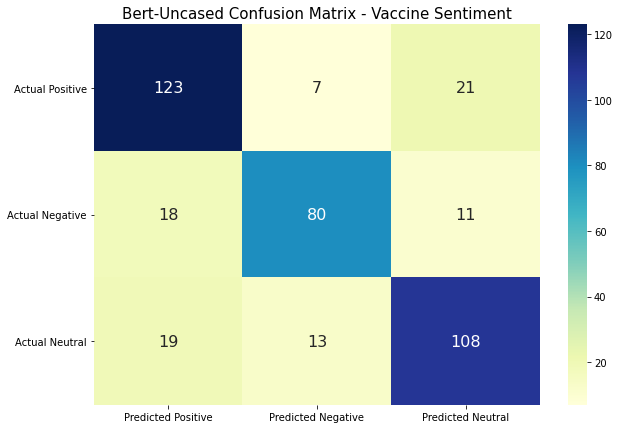

In [66]:
cm_3 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_3, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('Bert-Uncased Confusion Matrix - Vaccine Sentiment',fontsize = 15)

In [67]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'bert_uncased_m3', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.7775
Recall Score:  0.7775
f1 Score:  0.7775
Accuracy Score 0.7775
Macro Precision Score:  0.7800595238095238
Macro Recall Score:  0.7733143539936176
Macro f1 Score:  0.7759918650763126


##BERT EN UNCASED Classifier - Negative Sentiment Reason

In [68]:
epochs = 10

checkpoint_filepath = './m4_bert_uncased_/checkpoint'
model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m4_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [69]:
bert_uncased_m4 = build_classifier_model_softmax_5_class()

In [70]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [71]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [72]:
bert_uncased_m4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [73]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased_m4.fit(m4_train_dataset,validation_data=m4_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 46s 307ms/step - loss: 1.4471 - categorical_accuracy: 0.3814 - f1_m: 0.2604 - precision_m: 0.3690 - recall_m: 0.2291 - val_loss: 0.7067 - val_categorical_accuracy: 0.7600 - val_f1_m: 0.7600 - val_precision_m: 0.8551 - val_recall_m: 0.6923
Epoch 2/10
88/88 [==============================] - 26s 298ms/step - loss: 0.7752 - categorical_accuracy: 0.7060 - f1_m: 0.7033 - precision_m: 0.8560 - recall_m: 0.6061 - val_loss: 0.6358 - val_categorical_accuracy: 0.7950 - val_f1_m: 0.7955 - val_precision_m: 0.8568 - val_recall_m: 0.7452
Epoch 3/10
88/88 [==============================] - 26s 296ms/step - loss: 0.4257 - categorical_accuracy: 0.8509 - f1_m: 0.8452 - precision_m: 0.9146 - recall_m: 0.7887 - val_loss: 0.5603 - val_categorical_accuracy: 0.8150 - val_f1_m: 0.8152 - val_precision_m: 0.8644 - val_recall_m: 0.7740
Epoch 4/10
88/88 [==========================

In [74]:
bert_uncased_m4.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


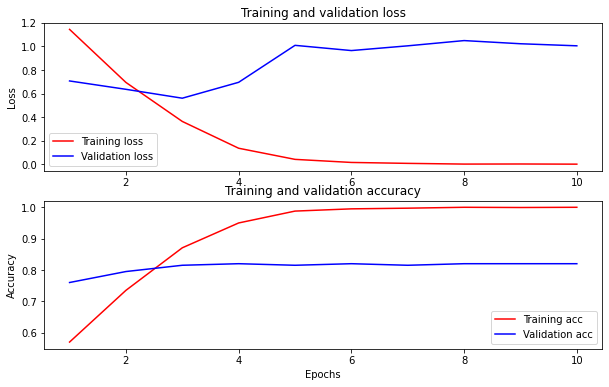

In [75]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [76]:
loss, accuracy, f1, precision, recall = bert_uncased_m4.evaluate(m4_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 82.999998
Test Loss:  0.9537016153335571
Test Precision:  0.8346666693687439
Test Recall:  0.8299999833106995
Test f1_score:  0.8322580456733704


In [77]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m4_test_dataset.as_numpy_iterator()):

  for item in batch[0]:


    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.argmax(bert_uncased_m4.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

    

  for item in batch[1]:
    true_label_list.append(tf.argmax(item))

Text(0.5, 1.0, 'Bert-Uncased Confusion Matrix - Vaccine - Negative Sentiment Reason')

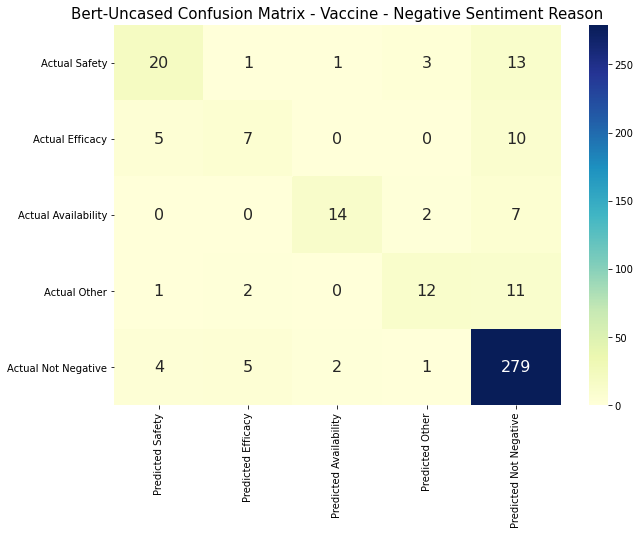

In [78]:

cm_4 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_4, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('Bert-Uncased Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

In [79]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'bert_uncased_m3', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))
model_final_test_results.append((bert_model_name, 'bert_uncased_m4', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.83
Recall Score:  0.83
f1 Score:  0.83
Accuracy Score 0.83
Macro Precision Score:  0.6990808823529411
Macro Recall Score:  0.574698921593163
Macro f1 Score:  0.6250650347521436


Text(0.5, 1.0, 'BERT-Uncased Confusion Matrix - Vaccine - Negative Sentiment Reason')

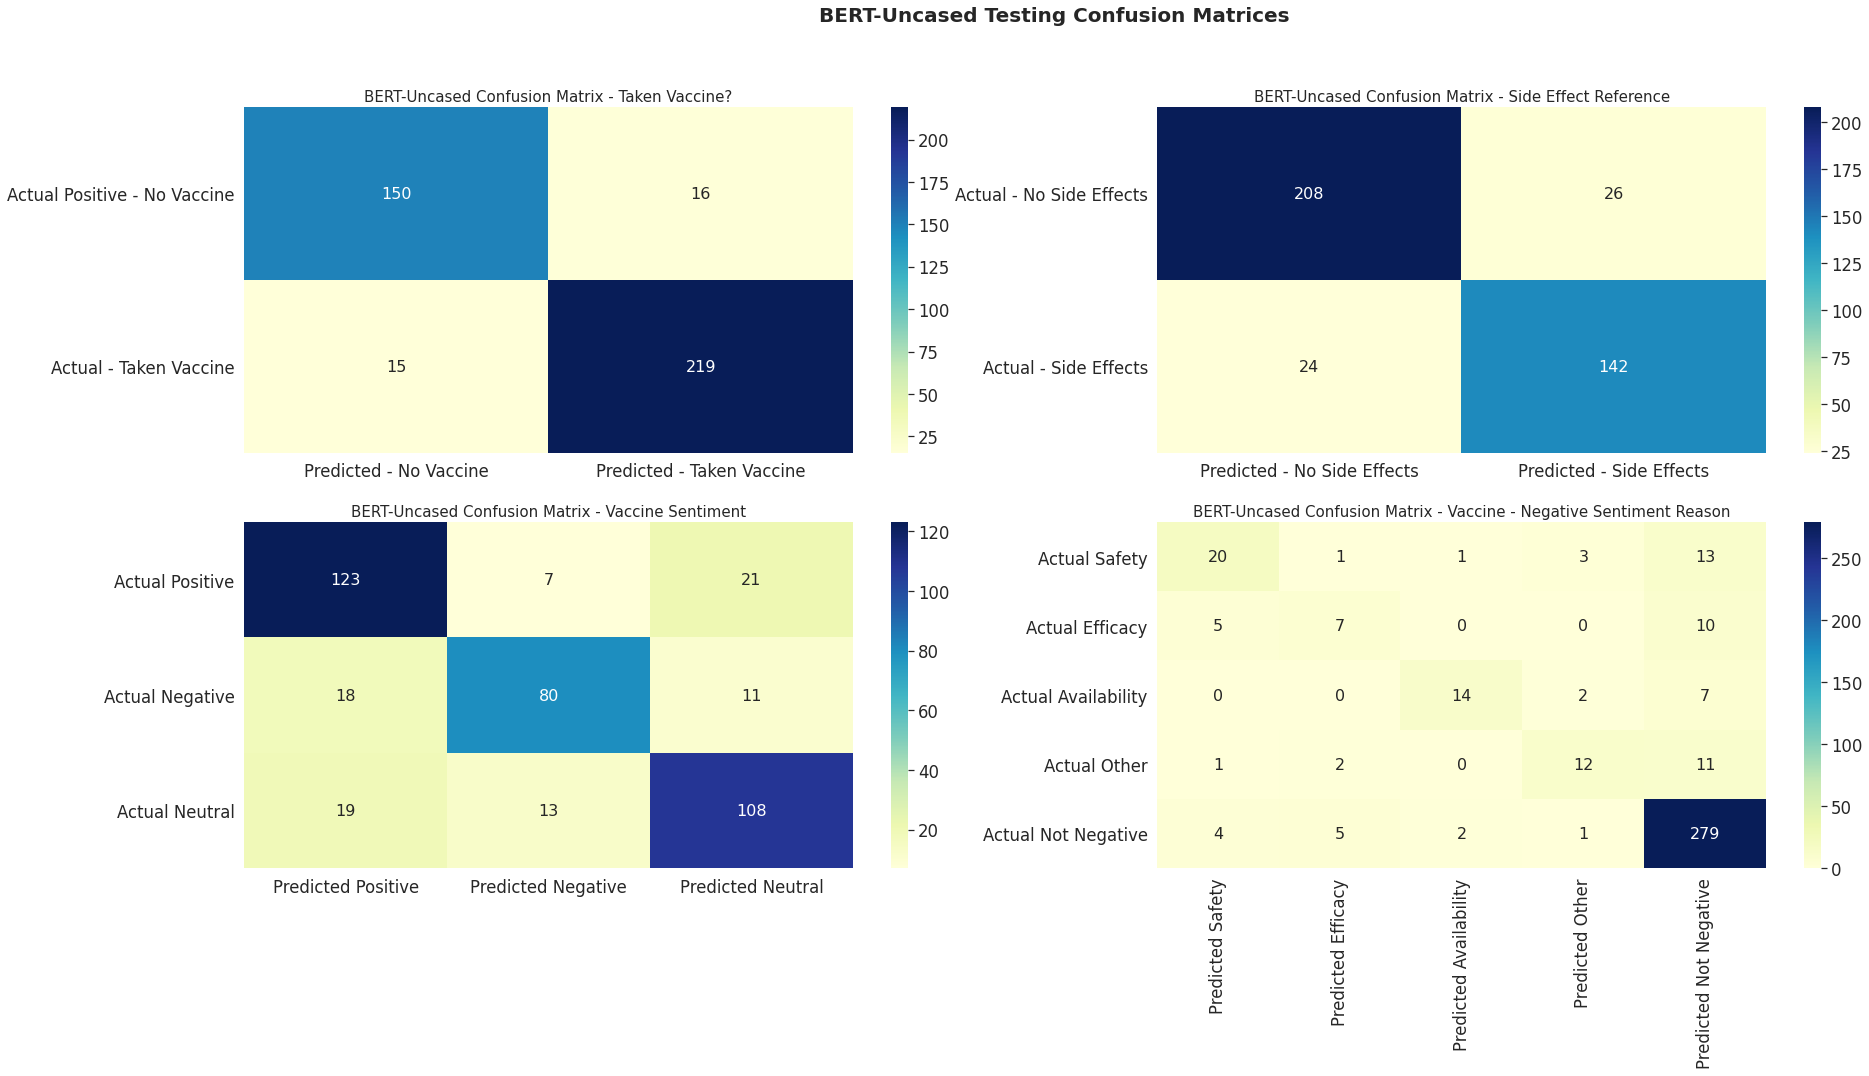

In [80]:
sn.set(font_scale=1.5)
fig, axes = plt.subplots(2, 2, figsize=(30, 14))

fig.suptitle('BERT-Uncased Testing Confusion Matrices',fontsize = 20,fontweight='bold')
a = sn.heatmap(cm_1, ax=axes[0,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')
a.set_title('BERT-Uncased Confusion Matrix - Taken Vaccine?',fontsize = 15)
b = sn.heatmap(cm_2, ax=axes[0,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')
b.set_title('BERT-Uncased Confusion Matrix - Side Effect Reference',fontsize = 15)
c = sn.heatmap(cm_3,ax=axes[1,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')
c.set_title('BERT-Uncased Confusion Matrix - Vaccine Sentiment',fontsize = 15)
d = sn.heatmap(data=cm_4, ax=axes[1,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')
d.set_title('BERT-Uncased Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

# Save Results to Excel

In [81]:
results = pd.DataFrame(model_final_test_results)

In [82]:
from datetime import datetime

In [83]:
results['timestamp'] = datetime.now()

In [84]:
results = results.rename(columns={0: "TensorHub Model Name", 1: "Classifier Task Name", 2: "Test Loss",3:'Test Micro Precision',4:'Test Micro Recall',5:'Test Micro F1 Score',6:'Test Accuracy',7:'Test Macro Precision',8:'Test Macro Recall',9:'Test Macro F1'})

In [85]:
saved_file = input('Enter a file name: ')
results.to_excel(saved_file)

Enter a file name: final_super.xlsx
